# AI-Based Trading Strategies

**Author:** J. Francisco Salazar

**Date:** 2025-02-15


## Gated Recurrent Unit (GRU) based Trading Strategy

# End-to-End Data Pipeline

### Import Libraries & Dependencies
We import the necessary libraries for:
- API connection (`requests`)
- Data handling (`pandas`, `numpy`)
- Logging (`logging`)
- Visualization (`matplotlib`)


In [1]:
# --- Standard Libraries ---
import os
import requests
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from time import sleep

## API Configuration
- Load the API Key from environment variables.
- Define the ticker (`AAPL.US` for S&P 500).
- Set the date range (`2014-2025`).

In [2]:
# --- API Configuration ---
API_KEY = os.getenv("EODHD_API_KEY")  # Load API Key securely
TICKER = "AAPL.US"
START_DATE = "2015-01-01"
END_DATE = "2025-01-01"
BASE_URL = "https://eodhd.com/api/eod/"

## API Request Function 
- Fetches historical data using the **EODHD API**.
- Implements **error handling & retry logic** to manage failed API calls.

In [3]:
def fetch_eod_data(ticker, api_key, start_date, end_date, retries=3, delay=5):
    """
    Fetches historical market data from EODHD API with retry logic.

    Parameters:
    - ticker (str): Stock or index ticker symbol
    - api_key (str): API authentication token
    - start_date (str): Start date for data retrieval
    - end_date (str): End date for data retrieval
    - retries (int): Number of retry attempts in case of failure
    - delay (int): Delay between retries (exponential backoff)

    Returns:
    - pd.DataFrame: Market data if successful, else None
    """
    url = f"{BASE_URL}{ticker}?api_token={api_key}&from={start_date}&to={end_date}&fmt=json"
    
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                if data:
                    logging.info(f"Successfully retrieved {len(data)} records.")
                    return pd.DataFrame(data)
                else:
                    logging.warning("API returned an empty dataset.")
            else:
                logging.error(f"API request failed with status {response.status_code}: {response.text}")
        except requests.RequestException as e:
            logging.error(f"API request error: {e}")

        sleep(delay * (2 ** attempt))  # Exponential backoff
    return None

## Fetch & Preprocess Data
- Convert `date` column to datetime format.
- Set `date` as index for time-series analysis.
- Convert numeric columns to `float`.
- Handle missing values using **forward-fill**.

In [4]:
df = fetch_eod_data(TICKER, API_KEY, START_DATE, END_DATE)

if df is not None:
    
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    
    df.set_index("date", inplace=True)

    numeric_cols = ["open", "high", "low", "close", "adjusted_close", "volume"]
    df[numeric_cols] = df[numeric_cols].astype(float)

    df.ffill(inplace=True)  

    display(df.head())

,open,high,low,close,adjusted_close,volume
date,,,,,,
2015-01-02,111.39,111.44,107.35,109.33,24.3204,212818400.0
2015-01-05,108.29,108.65,105.41,106.25,23.6353,257142000.0
2015-01-06,106.54,107.43,104.63,106.26,23.6375,263188400.0
2015-01-07,107.20,108.20,106.70,107.75,23.9690,160423600.0
2015-01-08,109.23,112.15,108.70,111.89,24.8899,237458000.0


## Data Visualization
- Plot **S&P 500 adjusted closing prices** over time.

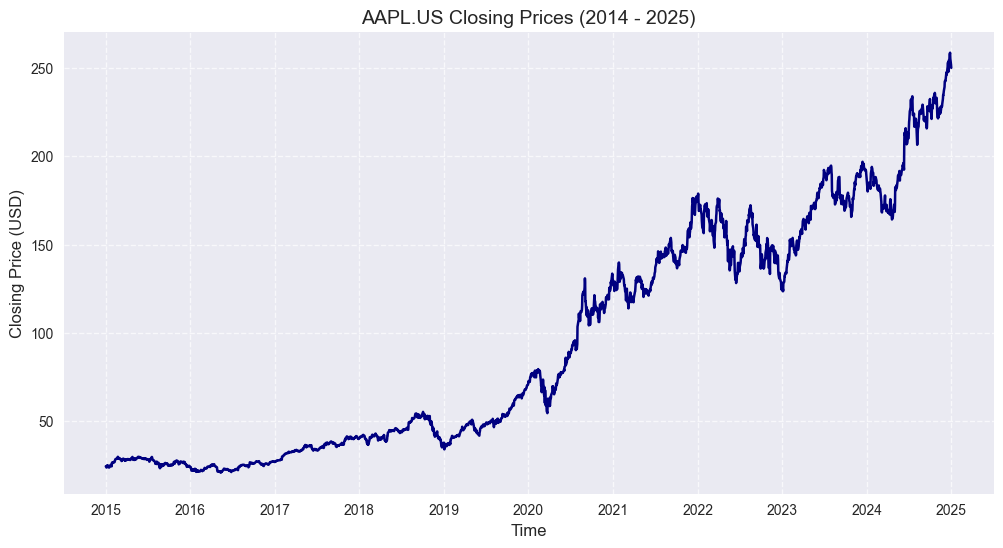

In [5]:
plt.style.use('seaborn-v0_8')

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["adjusted_close"], linewidth=1.8, color='navy')

plt.title("AAPL.US Closing Prices (2014 - 2025)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Closing Price (USD)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

plt.show()

## Feature Engineering & Transformation

In [6]:
# Compute log returns
df["log_returns"] = np.log(df["adjusted_close"] / df["adjusted_close"].shift(1))

### Volatility-Adjusted Returns:

In [7]:
# Rolling Volatility (10-day)
df["volatility_10"] = df["log_returns"].rolling(10).std()

# Volatility-Adjusted Returns
df["vol_adj_returns"] = df["log_returns"] / df["volatility_10"]

df.dropna(inplace=True)

df.head()

,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns
date,,,,,,,,,
2015-01-16,107.03,107.58,105.20,105.99,23.5774,314053200.0,-0.007803,0.020736,-0.376309
2015-01-20,107.84,108.97,106.50,108.72,24.1847,199599600.0,0.025432,0.020395,1.246939
2015-01-21,108.95,111.06,108.27,109.55,24.3694,194303600.0,0.007608,0.020443,0.372153
2015-01-22,110.26,112.47,109.72,112.40,25.0034,215185600.0,0.025684,0.021452,1.197281
2015-01-23,112.30,113.75,111.53,112.98,25.1324,185859200.0,0.005146,0.017999,0.285902


### Technical Indicators  

LSTM models **learn patterns from sequences**, so we should select indicators that enhance **trend detection, volatility awareness, and momentum signals**.

| **Category**              | **Indicator**                                      | **Best Periods** | **Why Useful?**                                   |
|---------------------------|---------------------------------------------------|----------------|--------------------------------------------------|
| **Moving Averages**        | **EMA (Exponential Moving Avg)**                 | **EMA(50, 200)** | Captures recent trend changes faster           |
| **Momentum Indicators**    | **RSI (Relative Strength Index)**                | **RSI(14)** | Identifies momentum & overbought/oversold conditions   |
| **Momentum Indicators**    | **MACD (Moving Avg Convergence Divergence)**     | **MACD(12,26,9)** | Detects momentum shifts & trend reversals   |
| **Volatility Indicators**  | **ATR (Average True Range)**                     | **ATR(14)** | Measures market volatility & stop-loss adjustments        |
| **Trend Indicators**       | **SAR (Parabolic SAR)**                          | **SAR(Default)** | Tracks trend direction & reversals                        |
| **Trend Indicators**       | **SLOPE (Slope Indicator)**                      | **SLOPE(14)** | Confirms trend strength                        |
| **Trend Indicators**       | **ADX (Average Directional Index)**              | **ADX(14)** | Measures trend strength without direction |
| **Volume Indicators**      | **OBV (On-Balance Volume)**                      | **OBV(Default)** | Confirms trend strength via volume              |


In [8]:
# Momentum Indicators: RSI & MACD
def compute_rsi(df, column="adjusted_close", period=14):
    delta = df[column].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = np.convolve(gain, np.ones(period)/period, mode='same')
    avg_loss = np.convolve(loss, np.ones(period)/period, mode='same')
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_macd(df, column="adjusted_close", short_period=12, long_period=26, signal_period=9):
    short_ema = df[column].ewm(span=short_period, adjust=False).mean()
    long_ema = df[column].ewm(span=long_period, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

# Moving Averages: EMA 50 & EMA 200
def compute_ema(df, column="adjusted_close", period=50):
    return df[column].ewm(span=period, adjust=False).mean()

def compute_ema_200(df, column="adjusted_close", period=200):
    return df[column].ewm(span=period, adjust=False).mean()

# Volatility Indicator: ATR
def compute_atr(df, period=14):
    tr = np.maximum(df["high"] - df["low"],
                     np.maximum(abs(df["high"] - df["adjusted_close"].shift()),
                                abs(df["low"] - df["adjusted_close"].shift())))
    return tr.rolling(window=period).mean()

# Trend Indicators: SAR, Slope & ADX
def compute_slope(df, column="adjusted_close", period=14):
    return df[column].diff(period) / period

def compute_sar(df, acceleration=0.02, maximum=0.2):
    sar = np.zeros(len(df))
    trend = 1  # Assume first trend is bullish
    extreme_point = df["high"].iloc[0]
    af = acceleration
    
    for i in range(1, len(df)):
        sar[i] = sar[i - 1] + af * (extreme_point - sar[i - 1]) if trend == 1 else sar[i - 1] - af * (sar[i - 1] - extreme_point)
        extreme_point = max(extreme_point, df["high"].iloc[i]) if trend == 1 else min(extreme_point, df["low"].iloc[i])
        af = min(af + acceleration, maximum)
    return sar

def compute_adx(df, period=14):
    plus_dm = np.maximum(df["high"].diff(), 0)
    minus_dm = np.maximum(-df["low"].diff(), 0)
    tr = np.maximum(df["high"] - df["low"],
                     np.maximum(abs(df["high"] - df["adjusted_close"].shift()),
                                abs(df["low"] - df["adjusted_close"].shift())))
    plus_di = 100 * (plus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
    minus_di = 100 * (minus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    return dx.rolling(window=period).mean()

# Volume Indicator: OBV
def compute_obv_vectorized(df):
    direction = np.sign(df["adjusted_close"].diff()).fillna(0)
    return (direction * df["volume"]).cumsum()


# Compute Indicators and Add to DataFrame
df["EMA_50"] = compute_ema(df, period=50)
df["EMA_200"] = compute_ema_200(df, period=200)
df["RSI_14"] = compute_rsi(df, period=14)
df["MACD"], df["MACD_Signal"] = compute_macd(df)
df["ATR_14"] = compute_atr(df, period=14)
df["SAR"] = compute_sar(df)
df["SLOPE_14"] = compute_slope(df, period=14)
df["ADX_14"] = compute_adx(df, period=14)
df["OBV"] = compute_obv_vectorized(df)

# Fill any NaNs from rolling calculations
df.fillna(0, inplace=True)

In [9]:
df.tail()

,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns,EMA_50,EMA_200,RSI_14,MACD,MACD_Signal,ATR_14,SAR,SLOPE_14,ADX_14,OBV
date,,,,,,,,,,,,,,,,,,,
2024-12-24,255.49,258.21,255.29,258.20,257.9164,23234700.0,0.011413,0.011190,1.019877,238.043478,216.974669,54.030171,6.067322,5.390178,4.137886,515.14,1.083807,79.585610,6.726805e+09
2024-12-26,258.19,260.10,257.63,259.02,258.7355,27237100.0,0.003171,0.010721,0.295765,238.854930,217.390200,53.772698,6.300015,5.572146,4.142171,515.14,1.140171,77.922991,6.754042e+09
2024-12-27,257.83,258.70,253.06,255.59,255.3093,42355300.0,-0.013331,0.012160,-1.096279,239.500200,217.767504,48.870290,6.137214,5.685159,4.365421,515.14,0.909714,74.023941,6.711687e+09
2024-12-30,252.23,253.50,250.75,252.20,251.9230,35557500.0,-0.013352,0.013224,-1.009674,239.987368,218.107360,43.880044,5.669591,5.682045,4.298943,515.14,0.388857,69.281663,6.676129e+09
2024-12-31,252.44,253.28,249.43,250.42,250.1450,39480700.0,-0.007083,0.012970,-0.546079,240.385707,218.426143,56.055227,5.096774,5.564991,4.368943,515.14,0.189079,63.932442,6.636649e+09


### Regime Detection:
Use Hidden Markov Models (HMMs) to identify market regimes (bull/bear) and create regime-specific features.

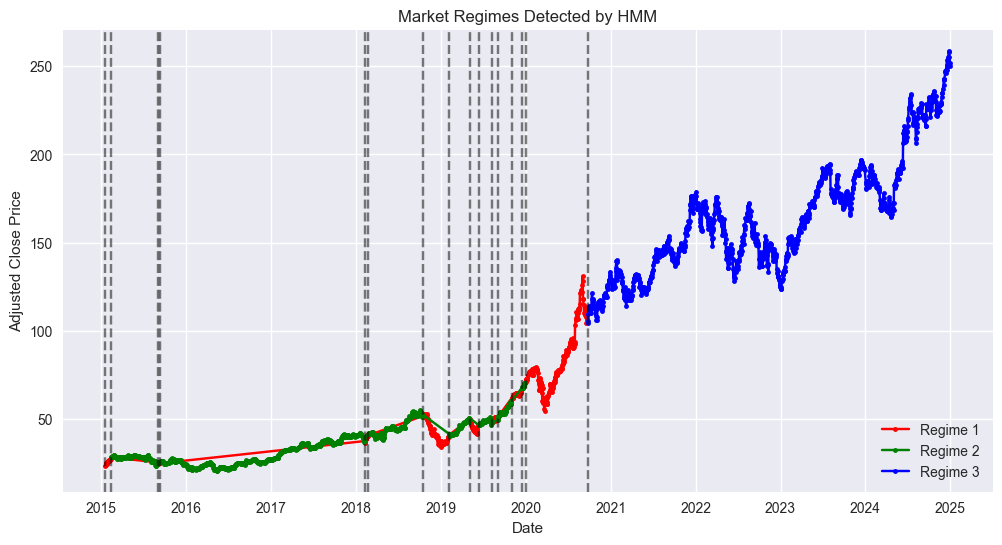

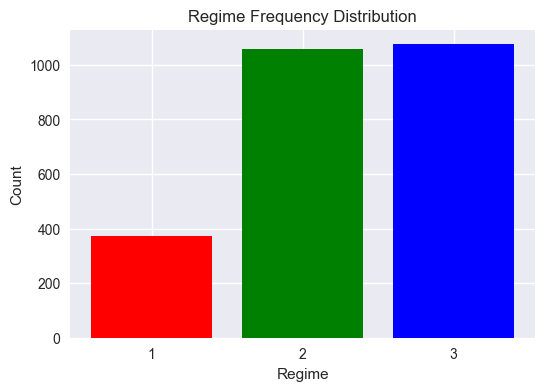

In [10]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode

# =========================
# Regime Detection with HMM
# =========================

# --- Step 1: Define Number of Hidden States (Regimes) ---
n_states = 3  # 3 regimes: Bullish, Bearish, Neutral

# --- Step 2: Regime Detection with HMM ---
# Selecting relevant features for HMM training
hmm_features = ["log_returns", "volatility_10", "RSI_14", "MACD", "ATR_14", "OBV"]

df_hmm = df[hmm_features].dropna()  # Avoid missing values
X = df_hmm.values  

# --- Step 3: Normalize Features for HMM ---
scaler_hmm = StandardScaler()
X_hmm_scaled = scaler_hmm.fit_transform(X)  # Standardize only HMM features

# --- Step 4: Train HMM Model ---
hmm_model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
hmm_model.fit(X_hmm_scaled)

# --- Step 5: Predict Market Regimes ---
df.loc[df_hmm.index, "regime"] = hmm_model.predict(X_hmm_scaled)

# --- Step 6: Ensure all rows have a regime assigned ---
df["regime"] = df["regime"].ffill().bfill()  

# --- Step 7: Apply Smoothing to Reduce Noise in Regime Changes ---
def rolling_mode(series, window=7):
    def safe_mode(x):
        m = mode(x, keepdims=True)
        return m.mode[0] if len(m.mode) > 0 else x.iloc[-1]
    # FIX: Use strictly forward-looking rolling (center=False)
    return series.rolling(window, center=False).apply(safe_mode, raw=False)

df["regime_smoothed"] = rolling_mode(df["regime"], window=7).ffill().bfill().astype(int)

# --- Step 8: Mark Major Regime Change Points ---
# FIX: Remove lookahead by not using shift(-15)
df["regime_change"] = df["regime_smoothed"].diff().ne(0).astype(int)
# (Optional alternative: If you prefer to confirm a change after 15 days, you could delay labeling:
# df["regime_change"] = df["regime_smoothed"].diff().ne(0).shift(15).fillna(0).astype(int))

# --- Step 9: Creating Regime-Based Features ---
# To avoid mixing non-contiguous periods with the same regime label, we create a block id:
df["block_id"] = df["regime_smoothed"].ne(df["regime_smoothed"].shift()).cumsum()

def regime_sma(df, column, window):
    # Compute rolling average within each contiguous block only
    return df.groupby("block_id")[column].apply(lambda x: x.rolling(window, min_periods=1).mean()).reset_index(level=0, drop=True)

# Apply Regime-Based Features
df["SMA_50_regime"] = regime_sma(df, "adjusted_close", 50)
df["SMA_200_regime"] = regime_sma(df, "adjusted_close", 200)
df["volatility_10_regime"] = regime_sma(df, "volatility_10", 10)
df["RSI_14_regime"] = regime_sma(df, "RSI_14", 14)

df.dropna(inplace=True)  # Drop rows with missing values

# --- Step 10: Fixing Regime Mapping and Visualization ---
# Remap 0,1,2 → 1,2,3 for consistent labeling
df["regime_smoothed"] = df["regime_smoothed"].map({0: 1, 1: 2, 2: 3})

# Define color mapping and labels for visualization
regime_colors = {1: "red", 2: "green", 3: "blue"}
regime_labels = {1: "Regime 1", 2: "Regime 2", 3: "Regime 3"}

plt.figure(figsize=(12, 6))
# Plot regime-based adjusted close prices
for regime, color in regime_colors.items():
    plt.plot(df[df["regime_smoothed"] == regime].index,
             df[df["regime_smoothed"] == regime]["adjusted_close"],
             linestyle='-', marker='.', label=regime_labels[regime], color=color)
# Highlight regime change points
for change_date in df[df["regime_change"] == 1].index:
    plt.axvline(change_date, color='black', linestyle="--", alpha=0.5)
plt.title("Market Regimes Detected by HMM")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()

# --- Step 11: Fixed Regime Frequency Distribution ---
plt.figure(figsize=(6, 4))
regime_counts = df["regime_smoothed"].value_counts().sort_index()
bars = plt.bar(regime_counts.index, regime_counts.values, color=[regime_colors[i] for i in regime_counts.index])
plt.xticks(ticks=regime_counts.index, labels=regime_counts.index)
plt.title("Regime Frequency Distribution")
plt.xlabel("Regime")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [11]:
# --- Step 1: Ensure "regime_smoothed" Exists  ---
if "regime_smoothed" not in df.columns:
    print("Warning: 'regime_smoothed' column is missing! Recreating it...")
    if "regime" in df.columns:
        df["regime_smoothed"] = df["regime"].astype(int)
    else:
        raise KeyError("Error: Neither 'regime_smoothed' nor 'regime' found in DataFrame!")

# --- Step 2: Drop Any Old One-Hot Encoded Regime Columns (But NOT "regime_smoothed") ---
old_regime_cols = [col for col in df.columns if col.startswith("regime_") and col != "regime_smoothed"]
if old_regime_cols:
    df.drop(columns=old_regime_cols, inplace=True, errors="ignore")
    
# Preserve "regime_smoothed" before encoding to prevent KeyErrors
df["regime_smoothed_backup"] = df["regime_smoothed"]

# --- Step 3: One-Hot Encode Regimes for LSTM Training ---
df = pd.get_dummies(df, columns=["regime_smoothed"], prefix="regime")

# Ensure All Expected Regime Columns Exist (Fixes Missing regime_1)
expected_regimes = ["regime_1", "regime_2", "regime_3"]
for col in expected_regimes:
    if col not in df.columns:
        df[col] = 0  # Add missing regime column and fill with 0s

if "regime_smoothed" not in df.columns:
    df["regime_smoothed"] = df["regime_smoothed_backup"]
    
df.drop(columns=["regime_smoothed_backup"], inplace=True, errors="ignore")

# --- Step 4: Convert One-Hot Encoded Values to Integers ---
df[expected_regimes] = df[expected_regimes].astype(int)

# --- Step 5: Verify the Fix ---
display(df.tail())  # Check if columns are correct

print("Regime counts in dataset:")
print(df[expected_regimes].sum())  # Count number of rows for each regime

,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns,EMA_50,...,regime,block_id,SMA_50_regime,SMA_200_regime,volatility_10_regime,RSI_14_regime,regime_1,regime_2,regime_3,regime_smoothed
date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,255.49,258.21,255.29,258.20,257.9164,23234700.0,0.011413,0.011190,1.019877,238.043478,...,2.0,16,235.564016,211.182574,0.008821,72.873665,0,0,1,3
2024-12-26,258.19,260.10,257.63,259.02,258.7355,27237100.0,0.003171,0.010721,0.295765,238.854930,...,2.0,16,236.071996,211.614172,0.009201,70.107087,0,0,1,3
2024-12-27,257.83,258.70,253.06,255.59,255.3093,42355300.0,-0.013331,0.012160,-1.096279,239.500200,...,2.0,16,236.552762,212.039090,0.009750,66.992588,0,0,1,3
2024-12-30,252.23,253.50,250.75,252.20,251.9230,35557500.0,-0.013352,0.013224,-1.009674,239.987368,...,2.0,16,236.958418,212.437770,0.010414,63.515434,0,0,1,3
2024-12-31,252.44,253.28,249.43,250.42,250.1450,39480700.0,-0.007083,0.012970,-0.546079,240.385707,...,2.0,16,237.271640,212.829451,0.011030,62.208633,0,0,1,3


Regime counts in dataset:
regime_1     373
regime_2    1058
regime_3    1075
dtype: int64


### Adding Lag Features (`lag_1` to `lag_7`) 

In [12]:
# Generate lag features (up to 7 days)
lags = 7
for lag in range(1, lags + 1):
    df[f'lag_{lag}'] = df['log_returns'].shift(lag)

# Drop NaN values caused by shifting
df.dropna(inplace=True)

# Check DataFrame structure after adding lag features 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2015-01-28 to 2024-12-31
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  2499 non-null   float64
 1   high                  2499 non-null   float64
 2   low                   2499 non-null   float64
 3   close                 2499 non-null   float64
 4   adjusted_close        2499 non-null   float64
 5   volume                2499 non-null   float64
 6   log_returns           2499 non-null   float64
 7   volatility_10         2499 non-null   float64
 8   vol_adj_returns       2499 non-null   float64
 9   EMA_50                2499 non-null   float64
 10  EMA_200               2499 non-null   float64
 11  RSI_14                2499 non-null   float64
 12  MACD                  2499 non-null   float64
 13  MACD_Signal           2499 non-null   float64
 14  ATR_14                2499 non-null   float64
 15  SAR

### Feature Correlation Matrix 

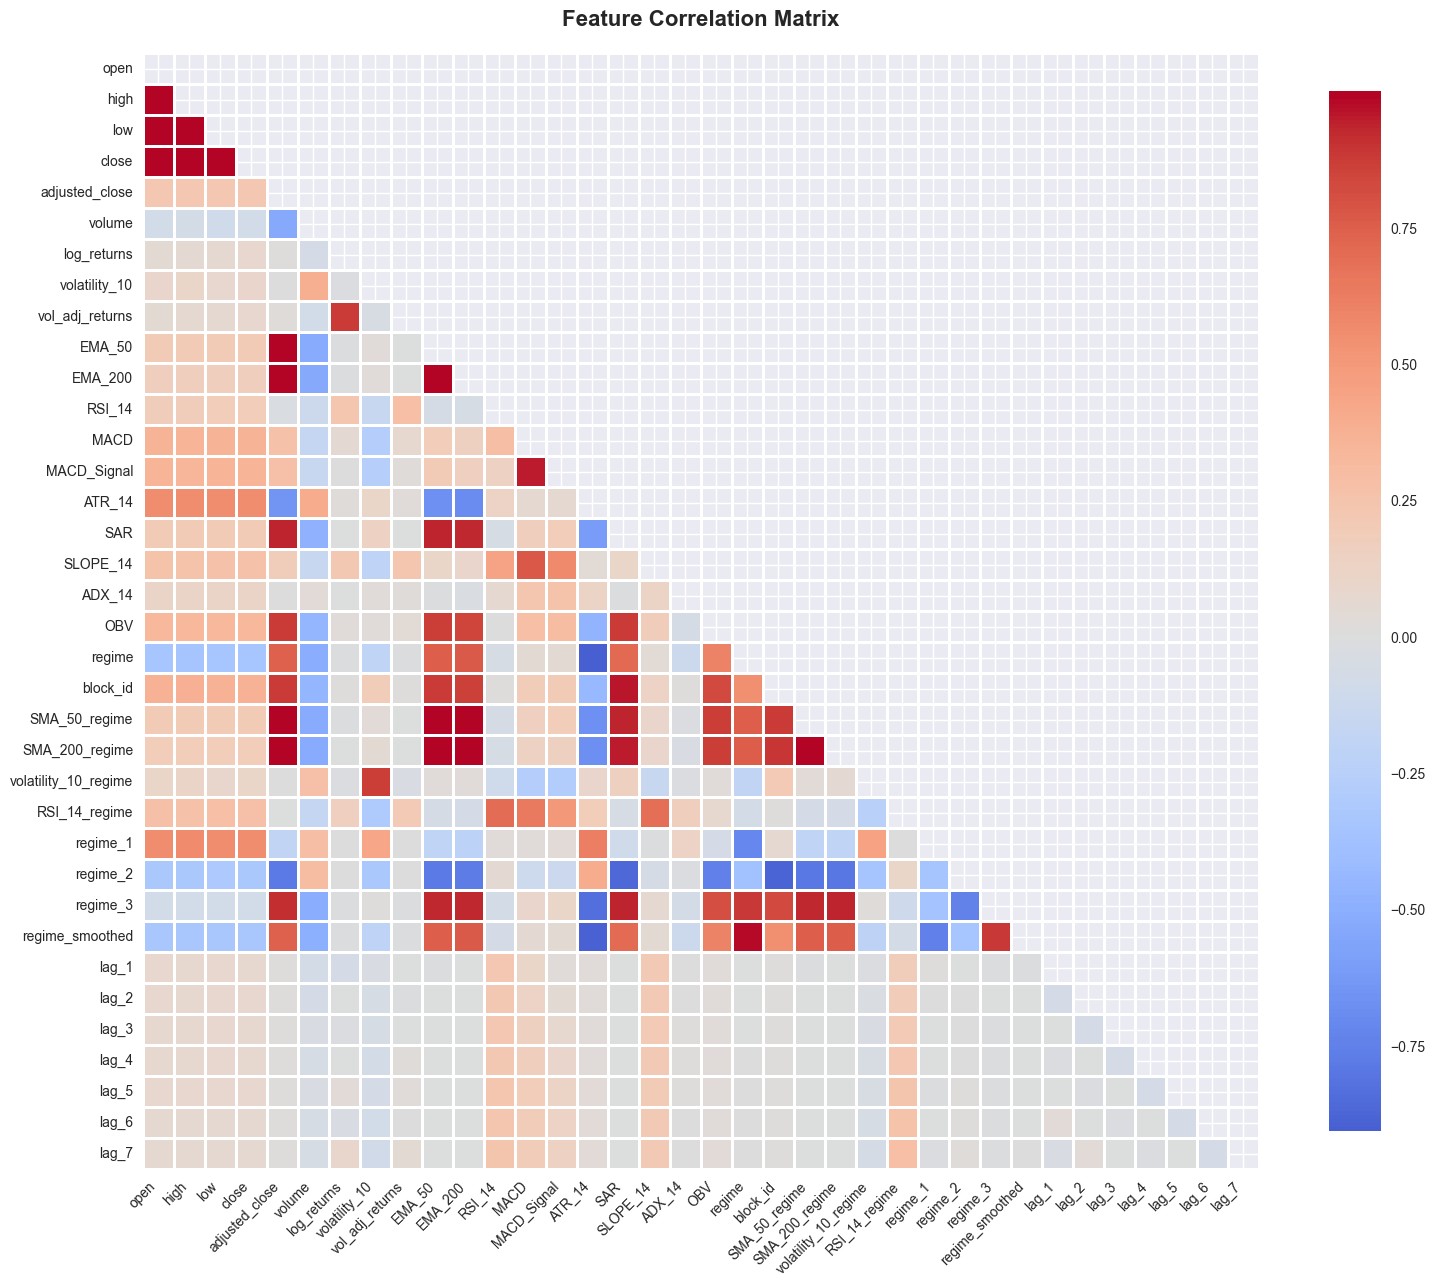

In [13]:
import seaborn as sns

corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Generate a mask to hide the upper triangle (reduce redundancy)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Dynamic figure sizing based on the number of features
n_features = corr_matrix.shape[0]
plt.figure(figsize=(n_features * 0.5, n_features * 0.5))  # Adjust multiplier if needed

sns.heatmap(
    corr_matrix, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", center=0,
    linewidths=1, cbar_kws={"shrink": 0.75}, square=True
)

# Label formatting
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Feature Correlation Matrix", fontsize=16, fontweight='bold', pad=20)

# Save figure (Change filename & format as needed)
# plt.savefig("feature_correlation_matrix.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Definition of Target Variable (`d`)

In [14]:
# --- Define Target Variable (`d`) ---
df['d'] = np.where(df['log_returns'].shift(-1) > 0, 1, 0)

# Drop only NaN values in 'd' caused by shifting (Last row)
df.dropna(subset=['d'], inplace=True)

# --- Corrected Feature Selection (X) ---
X = df[[col for col in [
    'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'log_returns', 
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 
    'volatility_10', 'vol_adj_returns', 'EMA_50', 'EMA_200',
    'RSI_14', 'MACD', 'MACD_Signal', 'ATR_14', 'SAR',
    'SLOPE_14', 'ADX_14', 'OBV', 'SMA_50_regime', 'SMA_200_regime', 
    'volatility_10_regime', 'RSI_14_regime', 'regime', 'regime_1', 'regime_2', 'regime_3'
] if col in df.columns]]  # Only include columns that exist

# --- Define Target Variable (y) ---
y = df['d']

# Verify Structure
print("Feature Matrix (X) Shape:", X.shape)
print("Target Variable (y) Shape:", y.shape)
display(df.tail())

Feature Matrix (X) Shape: (2499, 34)
Target Variable (y) Shape: (2499,)


,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns,EMA_50,...,regime_3,regime_smoothed,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,d
date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,255.49,258.21,255.29,258.20,257.9164,23234700.0,0.011413,0.011190,1.019877,238.043478,...,1,3,0.003060,0.018641,0.006990,-0.021654,0.009673,0.011659,0.000685,1
2024-12-26,258.19,260.10,257.63,259.02,258.7355,27237100.0,0.003171,0.010721,0.295765,238.854930,...,1,3,0.011413,0.003060,0.018641,0.006990,-0.021654,0.009673,0.011659,0
2024-12-27,257.83,258.70,253.06,255.59,255.3093,42355300.0,-0.013331,0.012160,-1.096279,239.500200,...,1,3,0.003171,0.011413,0.003060,0.018641,0.006990,-0.021654,0.009673,0
2024-12-30,252.23,253.50,250.75,252.20,251.9230,35557500.0,-0.013352,0.013224,-1.009674,239.987368,...,1,3,-0.013331,0.003171,0.011413,0.003060,0.018641,0.006990,-0.021654,0
2024-12-31,252.44,253.28,249.43,250.42,250.1450,39480700.0,-0.007083,0.012970,-0.546079,240.385707,...,1,3,-0.013352,-0.013331,0.003171,0.011413,0.003060,0.018641,0.006990,0


In [15]:
print(df['d'].value_counts(normalize=True))

d
1    0.531413
0    0.468587
Name: proportion, dtype: float64


### Feature Selection Using `ExtraTreesClassifier`

Training set shape: (1746, 34) (1746,)
Test set shape: (753, 34) (753,)


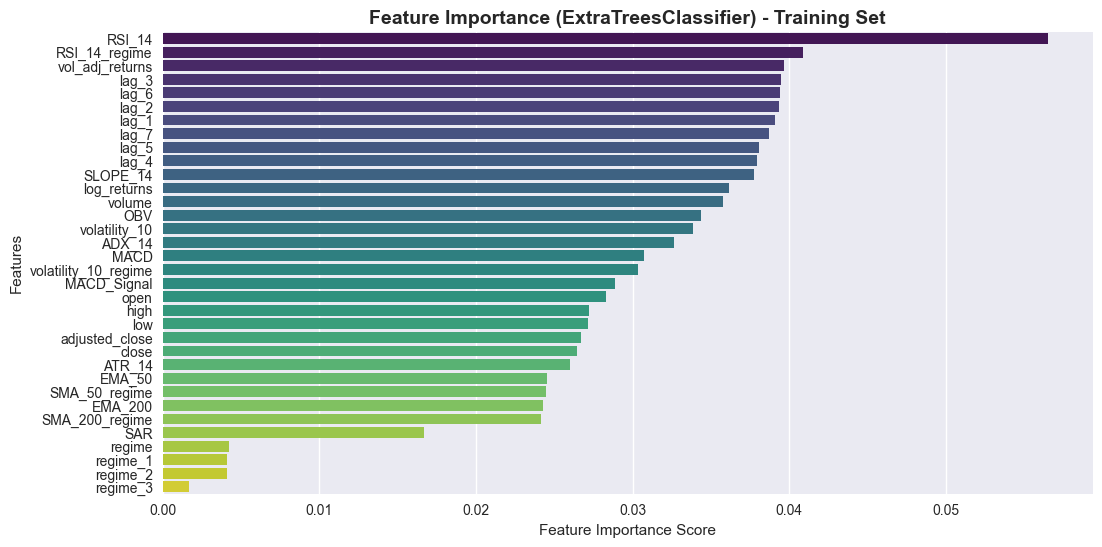

Top 15 features (Training Set): ['RSI_14', 'RSI_14_regime', 'vol_adj_returns', 'lag_3', 'lag_6', 'lag_2', 'lag_1', 'lag_7', 'lag_5', 'lag_4', 'SLOPE_14', 'log_returns', 'volume', 'OBV', 'volatility_10']
X_train_selected shape: (1746, 15)
X_test_selected shape: (753, 15)


In [16]:
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define a chronological cutoff date
train_cutoff = '2022-01-01'  # or pick another date

df_train = df.loc[:train_cutoff]
df_test = df.loc[train_cutoff:]

X_train = X.loc[df_train.index]
y_train = y.loc[df_train.index]
X_test = X.loc[df_test.index]
y_test = y.loc[df_test.index]

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# 2) Fit ExtraTrees ONLY on the training set
model_fs = ExtraTreesClassifier(n_estimators=100, random_state=42)
model_fs.fit(X_train, y_train)

# 3) Extract feature importances from TRAINING
feature_importance = pd.Series(
    model_fs.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# (Optional) plot these feature importances
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_importance.values, 
    y=feature_importance.index, 
    hue=feature_importance.index,
    palette="viridis",
    dodge=False,
    legend=False
)
plt.title("Feature Importance (ExtraTreesClassifier) - Training Set", fontsize=14, fontweight='bold')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

# 4) Select top N features from TRAINING
n_top = 15
top_features = feature_importance.index[:n_top]
print(f"Top {n_top} features (Training Set):", top_features.tolist())

# 5) Apply these features to both train & test
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print("X_train_selected shape:", X_train_selected.shape)
print("X_test_selected shape:", X_test_selected.shape)


### Preparation of `X` and `y` for LSTM Model

In [17]:
##############################
# Step 2: Scale Training Only
##############################
scaler = StandardScaler()
scaler.fit(X_train)            # Fit on training
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Transform test with same scaler

# Convert back to DataFrame for convenience
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

##############################
# Step 3: Use Top Features
##############################
# 'top_features' is assumed to be known (selected from a training-only feature selection step)
# e.g., top_features = ['RSI_14', 'lag_6', 'lag_3', 'lag_5', 'vol_adj_returns', ...]
X_train_selected = X_train_scaled[top_features]
X_test_selected = X_test_scaled[top_features]

# Align target with these new DataFrame indices
y_train = y_train.loc[X_train_selected.index]
y_test = y_test.loc[X_test_selected.index]

print("X_train_selected shape:", X_train_selected.shape)
print("y_train shape:", y_train.shape)
print("X_test_selected shape:", X_test_selected.shape)
print("y_test shape:", y_test.shape)

##############################
# Step 4: Sequence Creation
##############################
def create_sequences(X_df, y_series, seq_length=7):
    """
    Generates sequences from a DataFrame (X_df) and aligns with the target (y_series).
    Returns (X_seq, y_seq).
    """
    X_values = X_df.values  
    y_values = y_series.values  
    
    # For each valid starting index i, the sequence is [i : i + seq_length]
    X_seq = np.array([
        X_values[i : i + seq_length] 
        for i in range(len(X_values) - seq_length)
    ])
    # The label for that sequence is y at index i+seq_length
    y_seq = y_values[seq_length:]  
    
    return X_seq, y_seq

sequence_length = 7

# Safety checks
if len(X_train_selected) < sequence_length:
    raise ValueError("Not enough training data to generate sequences! Adjust sequence_length or dataset.")
if len(X_test_selected) < sequence_length:
    raise ValueError("Not enough test data to generate sequences! Adjust sequence_length or dataset.")

# Generate training sequences
X_seq_train, y_seq_train = create_sequences(X_train_selected, y_train, seq_length=sequence_length)
# Generate test sequences
X_seq_test, y_seq_test = create_sequences(X_test_selected, y_test, seq_length=sequence_length)

##############################
# Step 5: Confirm Shapes
##############################
print("\nSequence Shapes:")
print(f"X_seq_train: {X_seq_train.shape} (Samples={X_seq_train.shape[0]}, Time Steps={sequence_length}, Features={X_seq_train.shape[2]})")
print(f"y_seq_train: {y_seq_train.shape} (Samples={y_seq_train.shape[0]})")
print(f"X_seq_test:  {X_seq_test.shape} (Samples={X_seq_test.shape[0]}, Time Steps={sequence_length}, Features={X_seq_test.shape[2]})")
print(f"y_seq_test:  {y_seq_test.shape} (Samples={y_seq_test.shape[0]})")

X_train_selected shape: (1746, 15)
y_train shape: (1746,)
X_test_selected shape: (753, 15)
y_test shape: (753,)

Sequence Shapes:
X_seq_train: (1739, 7, 15) (Samples=1739, Time Steps=7, Features=15)
y_seq_train: (1739,) (Samples=1739)
X_seq_test:  (746, 7, 15) (Samples=746, Time Steps=7, Features=15)
y_seq_test:  (746,) (Samples=746)


# Model Implementation & Training
## Model Definition & Initialization

#### GRU Model

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input

# Hyperparameters
gru_units1 = 112  # Units for the first GRU layer
gru_units2 = 56  # Units for the second GRU layer
dropout_rate = 0.1  # Dropout rate
learning_rate = 0.00010617291854753388  # Learning rate
sequence_length = 7  # Sequence length (time steps)
n_features = 15  # Number of features

# Define the GRU model
model = Sequential([
    Input(shape=(sequence_length, n_features)),  # Input layer
    GRU(gru_units1, return_sequences=True),  # First GRU layer
    Dropout(dropout_rate),  # Dropout for regularization
    GRU(gru_units2, return_sequences=False),  # Second GRU layer
    Dropout(dropout_rate),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7, 112)         │        43,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 56)             │        28,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,961 (281.10 KB)

 Trainable params: 71,961 (281.10 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training with Rolling Cross-Validation
### Training Implementation

* Rolling Time-Series Cross-Validation → Ensures robust evaluation.
* Scaling within each fold → Prevents data leakage.
* Early Stopping → Stops training if validation loss stops improving.
* Standard Metrics → Accuracy, Precision, Recall, F1-Score

In [19]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# ----------------------------------------
# Define a function to create the GRU model
# ----------------------------------------
def get_gru_model(input_shape, gru_units1=112, gru_units2=56, dropout_rate=0.1, lr=00.00010617291854753388):
    model = Sequential([
        Input(shape=input_shape),

        # First GRU layer with sequences
        GRU(gru_units1, return_sequences=True),
        Dropout(dropout_rate),

        # Second GRU layer without sequences
        GRU(gru_units2, return_sequences=False),
        Dropout(dropout_rate),

        # Dense output layer for binary classification
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    
    return model

# ----------------------------------------
# Time-Series Cross-Validation Setup on Training Sequences Only
# ----------------------------------------
# Here, we assume that X_seq_train and y_seq_train have already been created.
# For example, from your previous code:
#    X_seq_train.shape -> (n_train_samples, sequence_length, n_features)
#    y_seq_train.shape -> (n_train_samples,)

# Configure TimeSeriesSplit.
# Note: We set n_splits=6 and test_size=252 to ensure there are enough samples.
tscv = TimeSeriesSplit(n_splits=6, test_size=252)

# Containers for storing predictions and metrics for each fold
predictions, true_labels = [], []
fold_metrics = []

# ----------------------------------------
# Loop through each CV fold on the training sequences
# ----------------------------------------
for fold, (train_index, test_index) in enumerate(tscv.split(X_seq_train)):
    print(f"\nProcessing Fold {fold + 1}/{tscv.n_splits}...")
    
    # Split the training sequences for this fold
    X_train_fold = X_seq_train[train_index]
    X_test_fold = X_seq_train[test_index]
    y_train_fold = y_seq_train[train_index]
    y_test_fold = y_seq_train[test_index]
    
    # -----------------------------
    # Scale data fold-by-fold:
    # -----------------------------
    # Reshape from 3D to 2D: (n_samples, sequence_length, n_features) -> (n_samples * sequence_length, n_features)
    nsamples_train, timesteps, n_features = X_train_fold.shape
    X_train_fold_2d = X_train_fold.reshape(-1, n_features)
    
    # Fit the scaler on the training fold only
    scaler = StandardScaler()
    scaler.fit(X_train_fold_2d)
    X_train_fold_scaled = scaler.transform(X_train_fold_2d).reshape(X_train_fold.shape)
    
    # Transform the test fold using the same scaler
    X_test_fold_2d = X_test_fold.reshape(-1, n_features)
    X_test_fold_scaled = scaler.transform(X_test_fold_2d).reshape(X_test_fold.shape)
    
    # -----------------------------
    # Build and train the model for this fold
    # -----------------------------
    model = get_gru_model((timesteps, n_features))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model.fit(X_train_fold_scaled, y_train_fold,
              validation_data=(X_test_fold_scaled, y_test_fold),
              epochs=50, batch_size=16,
              verbose=0, callbacks=[early_stopping])
    
    # -----------------------------
    # Make predictions on the test fold
    # -----------------------------
    pred = model.predict(X_test_fold_scaled).flatten()
    pred_binary = [1 if p >= 0.5 else 0 for p in pred]
    
    predictions.extend(pred)
    true_labels.extend(y_test_fold)
    
    # Compute fold-level metrics
    fold_accuracy = accuracy_score(y_test_fold, pred_binary)
    fold_precision = precision_score(y_test_fold, pred_binary)
    fold_recall = recall_score(y_test_fold, pred_binary)
    fold_f1 = f1_score(y_test_fold, pred_binary)
    
    fold_metrics.append({
        "fold": fold + 1,
        "accuracy": fold_accuracy,
        "precision": fold_precision,
        "recall": fold_recall,
        "f1_score": fold_f1
    })

# ----------------------------------------
# Aggregate and display fold metrics
# ----------------------------------------
df_fold_metrics = pd.DataFrame(fold_metrics)
df_fold_metrics.to_csv("fold_metrics.csv", index=False)
print("\nFold Metrics:")
display(df_fold_metrics)

# Compute overall metrics across all folds
predictions_binary = [1 if p >= 0.5 else 0 for p in predictions]
overall_accuracy = accuracy_score(true_labels, predictions_binary)
overall_precision = precision_score(true_labels, predictions_binary)
overall_recall = recall_score(true_labels, predictions_binary)
overall_f1 = f1_score(true_labels, predictions_binary)

print("\nCross-Validated Model Performance (Training Set):")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1-score: {overall_f1:.4f}")

print("\nMean Fold Performance:")
print(df_fold_metrics[["accuracy", "precision", "recall", "f1_score"]].mean())



Processing Fold 1/6...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Processing Fold 2/6...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Processing Fold 3/6...


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Processing Fold 4/6...


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Processing Fold 5/6...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Processing Fold 6/6...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Fold Metrics:


,fold,accuracy,precision,recall,f1_score
0,1,0.599206,0.631148,0.578947,0.603922
1,2,0.650794,0.680851,0.690647,0.685714
2,3,0.658730,0.650350,0.720930,0.683824
3,4,0.650794,0.664804,0.809524,0.730061
4,5,0.579365,0.575758,0.838235,0.682635
5,6,0.654762,0.690476,0.644444,0.666667



Cross-Validated Model Performance (Training Set):
Accuracy: 0.6323
Precision: 0.6447
Recall: 0.7155
F1-score: 0.6782

Mean Fold Performance:
accuracy     0.632275
precision    0.648898
recall       0.713788
f1_score     0.675470
dtype: float64


#### `Saving & Logging`

In [20]:
import shutil 

# Save the best model from cross-validation
model.save("best_gru_model.keras")

# Backup in case of overwriting
shutil.copy("best_gru_model.keras", "best_gru_model_backup.keras")

'best_gru_model_backup.keras'

**Up to this section, we have put together a production-grade pipeline for an LSTM-based trading strategy.**  

# Trading Signal Generation and Backtesting Module

In [21]:
def run_backtest(
    df, predictions, 
    transaction_cost=0.0001, 
    long_threshold=0.505, 
    short_threshold=0.495, 
    min_hold_days=3,
    stop_loss_threshold=-0.025,  # Stop-loss: Exit if daily loss > -2.5%
    rolling_loss_threshold=-0.05,  # Exit if rolling 10-day return < -5%
    volatility_scaling=True
):
    """
    Backtests a trading strategy with:
    - Lowered probability thresholds for better trade execution.
    - Adaptive holding period (exit when probability confidence weakens).
    - Stop-loss mechanism to prevent major drawdowns.
    - Volatility-based position scaling.
    
    Parameters:
        df (DataFrame): Historical price data including 'log_returns'.
        predictions (array-like): Model output probabilities for the test period.
        transaction_cost (float): Cost per trade.
        long_threshold (float): Minimum probability to enter a long trade.
        short_threshold (float): Maximum probability to enter a short trade.
        min_hold_days (int): Minimum days to hold a position once taken.
        stop_loss_threshold (float): Stop-loss exit threshold per trade.
        rolling_loss_threshold (float): Exit if rolling 10-day loss > threshold.
        volatility_scaling (bool): If True, position size scales based on volatility.

    Returns:
        df_backtest (DataFrame): DataFrame with backtest results including an equity curve.
    """
    df_backtest = df.copy()
    
    # Align predictions with the last len(predictions) rows of df_backtest
    df_backtest['p'] = np.nan
    df_backtest.loc[df_backtest.index[-len(predictions):], 'p'] = predictions

    # Generate raw trading signals based on adjusted thresholds
    df_backtest['raw_signal'] = np.select(
        [df_backtest['p'] >= long_threshold, df_backtest['p'] <= short_threshold],
        [1, -1], default=0
    )

    # ---------------------------
    # Adaptive Holding Period
    # ---------------------------
    raw_signals = df_backtest['raw_signal']
    final_positions = []
    current_position = 0
    hold_counter = 0

    for i in range(len(raw_signals)):
        if hold_counter > 0:
            # Continue holding the position
            final_positions.append(current_position)
            hold_counter -= 1
        else:
            # Allow new signal entry
            if raw_signals.iloc[i] != 0:
                current_position = raw_signals.iloc[i]
                hold_counter = min_hold_days - 1  # Hold for at least min_hold_days
                final_positions.append(current_position)
            else:
                # Exit if probability confidence weakens
                current_position = 0
                final_positions.append(0)

    df_backtest['po'] = final_positions
    df_backtest['po_shifted'] = df_backtest['po'].shift(1).fillna(0)  # Avoid look-ahead bias

    # ---------------------------
    # Stop-Loss Implementation
    # ---------------------------
    df_backtest['daily_return'] = df_backtest['po_shifted'] * df_backtest['log_returns']
    
    # Apply stop-loss: Exit position if loss exceeds stop_loss_threshold
    stop_loss_exit = df_backtest['daily_return'] <= stop_loss_threshold
    df_backtest.loc[stop_loss_exit, 'po_shifted'] = 0

    # Apply rolling 10-day loss exit condition
    df_backtest['rolling_loss'] = df_backtest['daily_return'].rolling(10).sum()
    df_backtest.loc[df_backtest['rolling_loss'] <= rolling_loss_threshold, 'po_shifted'] = 0

    # ---------------------------
    # Volatility-Based Position Sizing
    # ---------------------------
    if volatility_scaling:
        df_backtest['volatility_30d'] = df_backtest['log_returns'].rolling(30).std()
        avg_volatility = df_backtest['volatility_30d'].mean()
        df_backtest['position_size'] = df_backtest['po_shifted'] * (avg_volatility / df_backtest['volatility_30d'])
    else:
        df_backtest['position_size'] = df_backtest['po_shifted']

    # ---------------------------
    # Compute Strategy Returns
    # ---------------------------
    df_backtest['strategy_log_return'] = df_backtest['position_size'] * df_backtest['log_returns']

    # ---------------------------
    # Apply Transaction Costs
    # ---------------------------
    df_backtest['trade_cost'] = transaction_cost * df_backtest['po'].diff().abs().fillna(0)
    df_backtest['strategy_net_log_return'] = df_backtest['strategy_log_return'] - df_backtest['trade_cost']

    # ---------------------------
    # Compute Equity Curve
    # ---------------------------
    df_backtest['equity_curve'] = np.exp(df_backtest['strategy_net_log_return'].cumsum())

    return df_backtest

#  Run the backtest
df_backtest = run_backtest(df, predictions)

#  Print results
print(df_backtest[['log_returns', 'p', 'po', 'strategy_log_return', 'trade_cost', 'strategy_net_log_return', 'equity_curve']].tail())



            log_returns         p  po  strategy_log_return  trade_cost  \
date                                                                     
2024-12-24     0.011413  0.607300   1             0.021790         0.0   
2024-12-26     0.003171  0.650189   1             0.006082         0.0   
2024-12-27    -0.013331  0.586423   1            -0.023852         0.0   
2024-12-30    -0.013352  0.560387   1            -0.022991         0.0   
2024-12-31    -0.007083  0.447334   1            -0.012687         0.0   

            strategy_net_log_return  equity_curve  
date                                               
2024-12-24                 0.021790     58.622624  
2024-12-26                 0.006082     58.980276  
2024-12-27                -0.023852     57.590104  
2024-12-30                -0.022991     56.281157  
2024-12-31                -0.012687     55.571637  


In [22]:
#  Run the backtest (Keep this)
df_backtest = run_backtest(df, predictions)

#  Print results
print(df_backtest[['log_returns', 'p', 'po', 'strategy_log_return', 'trade_cost', 'strategy_net_log_return', 'equity_curve']].tail())

            log_returns         p  po  strategy_log_return  trade_cost  \
date                                                                     
2024-12-24     0.011413  0.607300   1             0.021790         0.0   
2024-12-26     0.003171  0.650189   1             0.006082         0.0   
2024-12-27    -0.013331  0.586423   1            -0.023852         0.0   
2024-12-30    -0.013352  0.560387   1            -0.022991         0.0   
2024-12-31    -0.007083  0.447334   1            -0.012687         0.0   

            strategy_net_log_return  equity_curve  
date                                               
2024-12-24                 0.021790     58.622624  
2024-12-26                 0.006082     58.980276  
2024-12-27                -0.023852     57.590104  
2024-12-30                -0.022991     56.281157  
2024-12-31                -0.012687     55.571637  


# AI Strategy Performance Review

## Plot 1: Actual Returns vs Predicted Returns
Shows how well the signals align with actual movements.

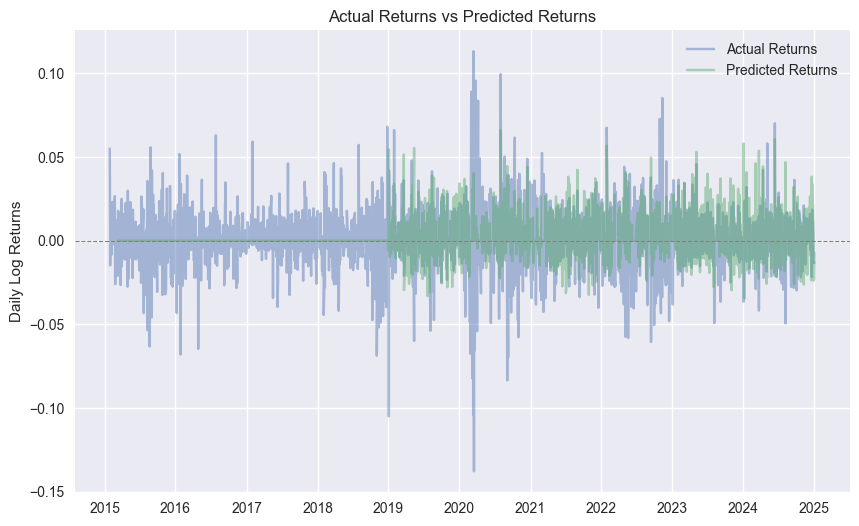

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(df_backtest.index, df_backtest['log_returns'], label="Actual Returns", alpha=0.45)
plt.plot(df_backtest.index, df_backtest['strategy_log_return'], label="Predicted Returns", alpha=0.45)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Actual Returns vs Predicted Returns")
plt.ylabel("Daily Log Returns")
plt.legend()
plt.show()


## Plot 2: Equity Curve of the Strategy
Show the cumulative performance over time.

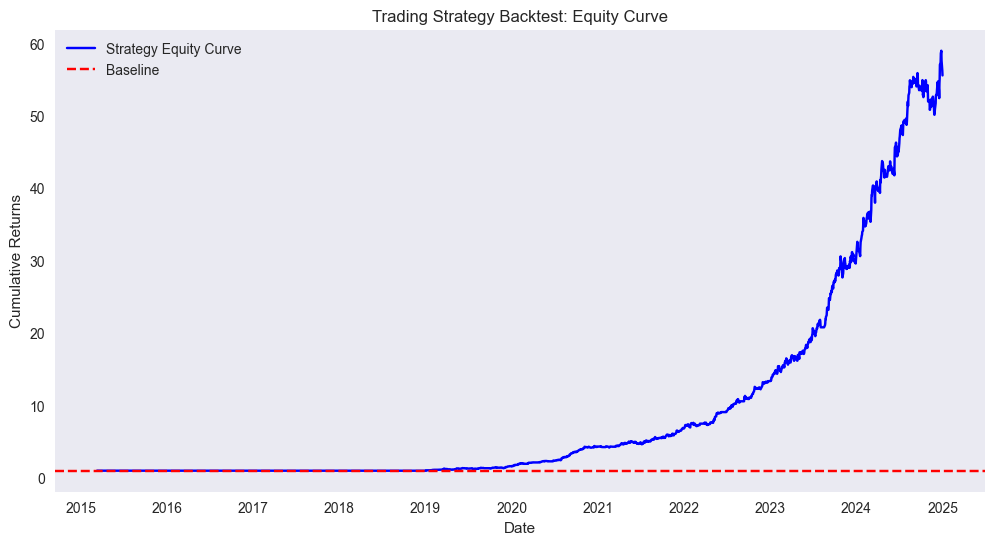

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df_backtest.index, df_backtest['equity_curve'], label="Strategy Equity Curve", color='blue')
plt.axhline(1.0, linestyle='--', color='red', label="Baseline")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Trading Strategy Backtest: Equity Curve")
plt.legend()
plt.grid()
plt.show()


## Plot 3: Strategy vs. Benchmark Comparison
Illustrate whether the strategy outperforms a simple buy-and-hold benchmark.

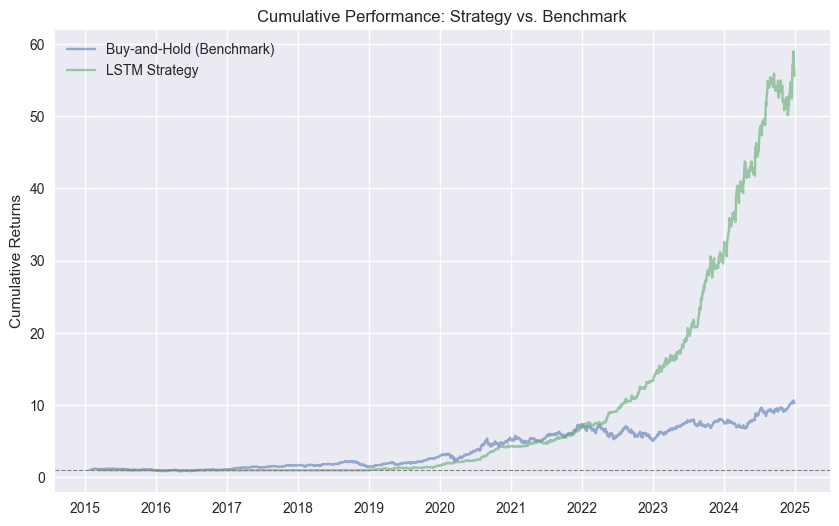

In [25]:
# Convert log returns to cumulative returns for buy-and-hold:
df_backtest['buy_and_hold'] = np.exp(df_backtest['log_returns'].cumsum())
df_backtest['cumulative_strategy'] = df_backtest['equity_curve']

plt.figure(figsize=(10, 6))
plt.plot(df_backtest.index, df_backtest['buy_and_hold'], label="Buy-and-Hold (Benchmark)", alpha=0.55)
plt.plot(df_backtest.index, df_backtest['cumulative_strategy'], label="LSTM Strategy", alpha=0.55)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
plt.title("Cumulative Performance: Strategy vs. Benchmark")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()


## `quantstats` Analytics Module


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2018-12-28   2018-12-28
End Period          2024-12-31   2024-12-31
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       84.0%

Cumulative Return   571.62%      5,457.16%
CAGR﹪              24.44%       58.61%

Sharpe              1.18         3.27
Prob. Sharpe Ratio  99.81%       100.0%
Sortino             1.76         6.32
Sortino/√2          1.24         4.47
Omega               1.84         1.84

Max Drawdown        -31.43%      -13.12%
Longest DD Days     514          94

Gain/Pain Ratio     0.24         0.84
Gain/Pain (1M)      1.46         12.8

Payoff Ratio        1.52         1.66
Profit Factor       1.24         1.84
Common Sense Ratio  1.23         2.85
CPC Index           1.02         1.63
Tail Ratio          1.0          1.55
Outlier Win Ratio   3.47         4.89
Outlier Loss Ratio  2.87         4.51

MTD                 5.52%        9.09%
3M         

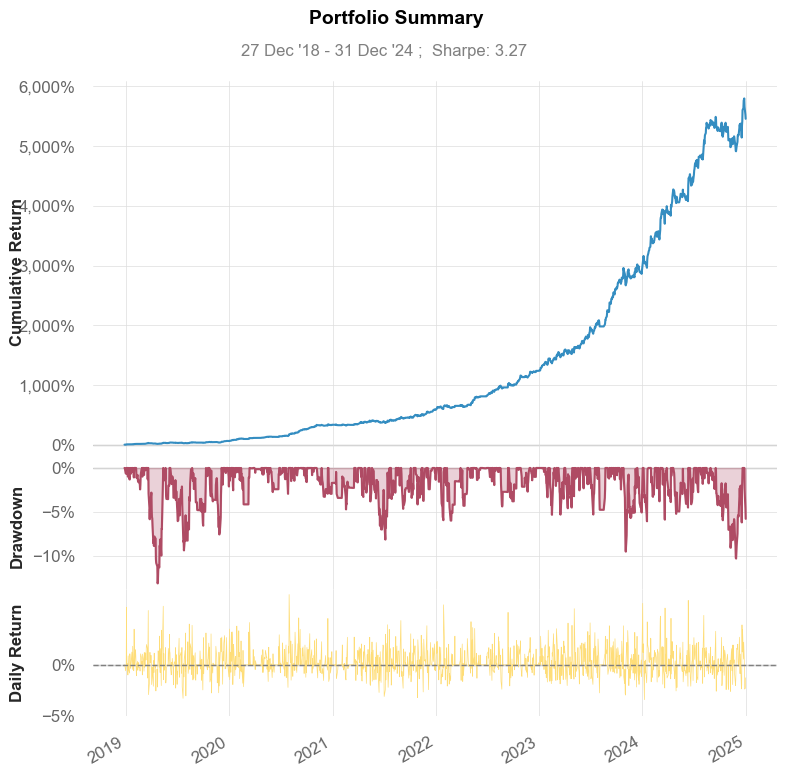

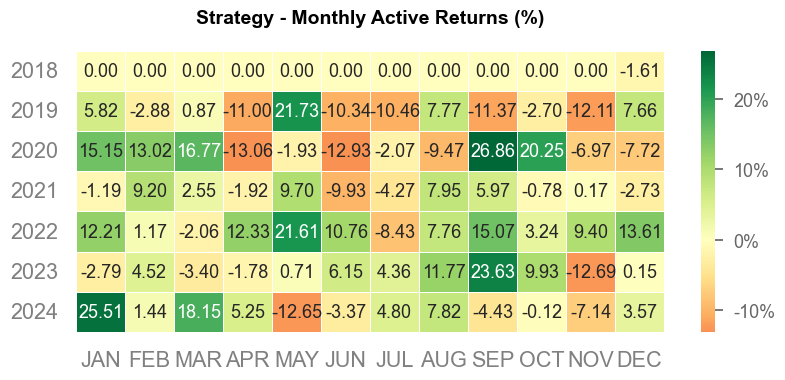

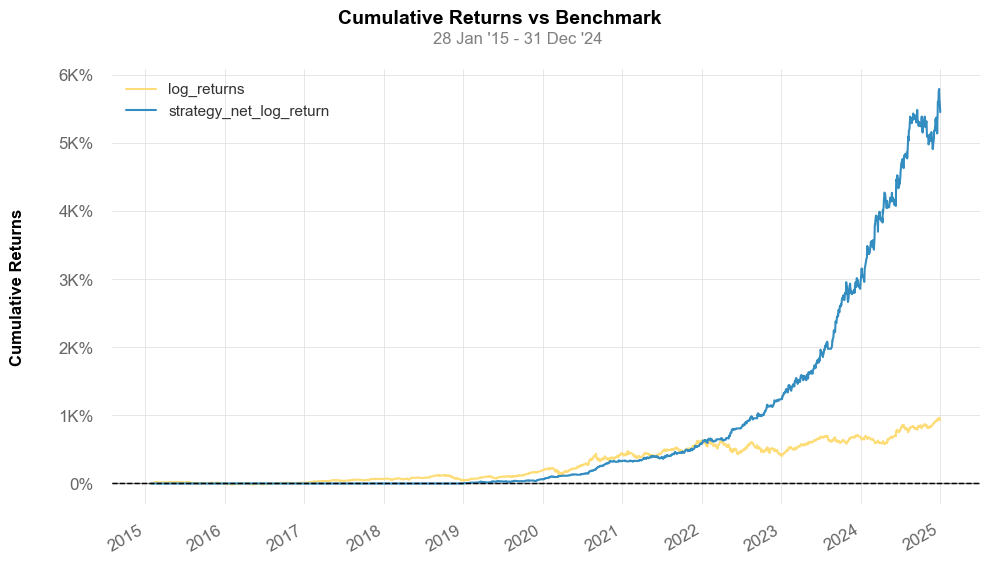

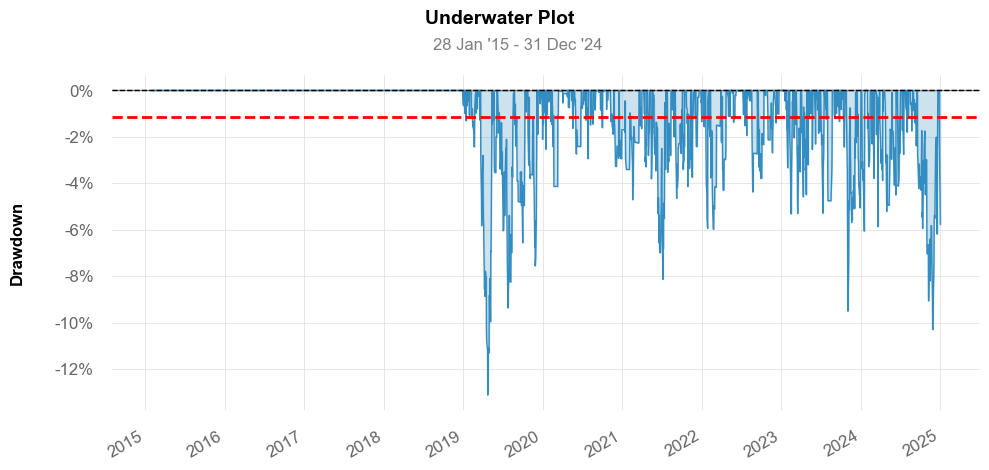

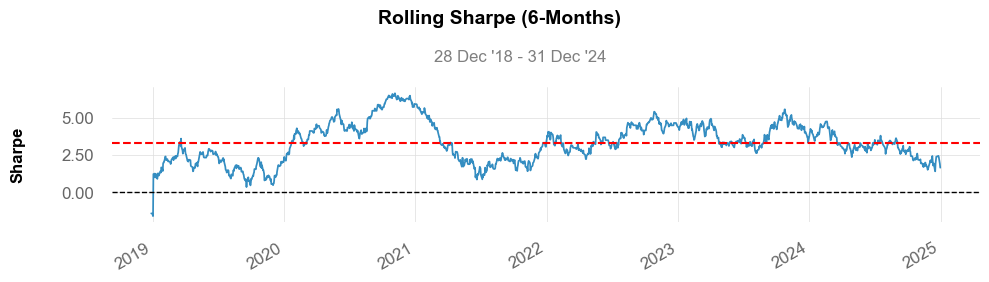

In [26]:
# Convert net log returns to simple daily returns:
strategy_simple_returns = np.exp(df_backtest['strategy_net_log_return']) - 1
benchmark_simple_returns = np.exp(df_backtest['log_returns']) - 1

import quantstats as qs

# Generate a Performance Report
qs.reports.basic(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Cumulative Returns Comparison (Strategy vs. Benchmark)
qs.plots.returns(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Drawdown Analysis
qs.plots.drawdown(strategy_simple_returns)

# Rolling Sharpe Ratio
qs.plots.rolling_sharpe(strategy_simple_returns)


## Hyperparameter Tuning with Optuna

## Bayesian Optimization for More Efficient Tuning